In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchani
import random
import pickle
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

from ase import units, Atoms
from ase.build import molecule
from tqdm import tqdm
from copy import deepcopy
from torch import optim
from scipy.constants import speed_of_light, N_A
from geomloss.samples_loss import SamplesLoss

import matplotlib
import matplotlib.pyplot as plt

import schnetpack as spk
from schnetpack.datasets import QM9

from adamAsynch import Adam

<stdin>:1:18: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:18: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:18: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:18: fatal error: cuda.h: No such file or directory
compilation terminated.



# Train the force field

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchani.models.ANI2x(periodic_table_index=True).to(device)

In [3]:
ANI_model_params_H = [[j for j in i.H] for i in model.neural_networks]
ANI_model_params_C = [[j for j in i.C] for i in model.neural_networks]
ANI_model_params_N = [[j for j in i.N] for i in model.neural_networks]
ANI_model_params_O = [[j for j in i.O] for i in model.neural_networks]
ANI_model_params_S = [[j for j in i.S] for i in model.neural_networks]
ANI_model_params_Cl = [[j for j in i.Cl] for i in model.neural_networks]
ANI_model_params_list = [ANI_model_params_H, ANI_model_params_C, ANI_model_params_N, ANI_model_params_O, ANI_model_params_S, ANI_model_params_Cl]
ANI_model_params_elems = list(itertools.chain(*[list(itertools.chain(*i)) for i in ANI_model_params_list]))

ANI_model_params_elems = ANI_model_params_elems[:72] + ANI_model_params_elems[73:]
ANI_model_params_elems = ANI_model_params_elems[:91] + ANI_model_params_elems[91:]

In [4]:
atomic_nums_dict = {"H":1, "B":5, "C":6, "N":7, "O":8, "F":9, "S":16, "Cl":17, "Br":35}
atomic_mass_dict = {1:1, 6:12, 7:14, 8:16, 9:19, 16:32, 17:35.5}
atomic_syms_dict = {1:"H", 5:"B", 6:"C", 7:"N", 8:"O", 9:"F", 16:"S", 17:"Cl", 35:"Br"}

In [3]:
data = pickle.load(open("/data/lrl/QM9_bugger/qm9_Full_1.pickle", "rb")) + \
       pickle.load(open("/data/lrl/QM9_bugger/qm9_Full_2.pickle", "rb")) + \
       pickle.load(open("/data/lrl/QM9_bugger/qm9_Full_3.pickle", "rb")) + \
       pickle.load(open("/data/lrl/QM9_bugger/qm9_Full_4.pickle", "rb")) + \
       pickle.load(open("/data/lrl/QM9_bugger/qm9_Full_5.pickle", "rb"))
dataset_qm = [[data[i]["atoms"], data[i]["coord"], data[i]["Sum of electronic and thermal Free Energies"]/27.2114,
            data[i]["freq"], data[i]["IR Inten"]] for i in range(len(data))]

data = pickle.load(open("/data/lrl/NAS_503_share/BindingDB_pickle/1.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/BindingDB_pickle/2.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/BindingDB_pickle/3.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/BindingDB_pickle/4.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/BindingDB_pickle/5.pkl", "rb"))
dataset_bdb = [[data[i]["atoms"], data[i]["coord"], data[i]["Sum of electronic and thermal Free Energies"]/27.2114,
            data[i]["freq"], data[i]["IR Inten"]] for i in range(len(data))]


data = pickle.load(open("/data/lrl/NAS_503_share/ChemBL_pickle/1.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/ChemBL_pickle/2.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/ChemBL_pickle/3.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/ChemBL_pickle/4.pkl", "rb")) + \
       pickle.load(open("/data/lrl/NAS_503_share/ChemBL_pickle/5.pkl", "rb"))
dataset_cbl = [[data[i]["atoms"], data[i]["coord"], data[i]["Sum of electronic and thermal Free Energies"]/27.2114,
            data[i]["freq"], data[i]["IR Inten"]] for i in range(len(data))]

In [4]:
dataset = dataset_qm + dataset_bdb + dataset_cbl
random.shuffle(dataset)

In [11]:
loss_fn = nn.MSELoss()

def train(_epoch, _model, _opt, _dataset, num=8):
    _model.train()
    _opt.zero_grad()
    total_loss = 0
    random.shuffle(_dataset)
    
    for atoms, coord, energy, freqs, intns in tqdm(_dataset[:num], ncols=50):

        coordinates = torch.tensor([coord], requires_grad=True, device=device, dtype=torch.float32).view(1,-1,3)
        species = torch.tensor(np.array([atoms]), device=device).view(1,-1)
        energies = _model((species, coordinates)).energies/27.2114 ## hatree to eV    

        loss = loss_fn(energies, torch.Tensor([energy]).double().to("cuda"))
        loss.backward()
        _opt.step()
        total_loss += loss.item()
    
    print("Train epoch: {}, the training loss is {}.".format(str(_epoch).rjust(4,"0"), total_loss))    
    return total_loss/num

def test(_model, _data):
    _model.eval()
    atoms, coord, energy, freqs, intns = _data
    coordinates = torch.tensor([coord], requires_grad=True, device=device, dtype=torch.float32).view(1,-1,3)
    species = torch.tensor(np.array([atoms]), device=device).view(1,-1)
    energies = _model((species, coordinates)).energies/27.2114 ## hatree to eV   
    return energies

In [77]:
opts = []
for i in tqdm(range(int(len(ANI_model_params_elems))), ncols=50):
    opts.append(Adam([{'params': ANI_model_params_elems[i].parameters()}], lr=5e-4))

In [29]:
losses = []

In [14]:
for i in range(len(ANI_model_params_elems)):
    losses.append(train(i, model, opts[i], dataset, num=64))

    torch.save(model.state_dict(),
               "./models/asynch_torchani_models_20221210/{}_{}.pt".format(str(i).rjust(3, "0"), losses[-1]))

# Test the tuning result

In [65]:
def test_accuracy(_model, _dataset):
    _model.eval()
    truth, preds = [], []
    for data in tqdm(_dataset, ncols=80):
        atoms, coord, energy, freqs, intns = data
        coordinates = torch.tensor([coord], requires_grad=True, device=device, dtype=torch.float32).view(1,-1,3)
        species = torch.tensor(np.array([atoms]), device=device).view(1,-1)
        energies = _model((species, coordinates)).energies/27.2114 ## hatree to eV
        truth.append(energy)
        preds.append(energies.item())
    return truth, preds

In [95]:
t, p = test_accuracy(vanilla_model, dataset_qm[:1000])
(((np.array(t)-np.array(p))**2).sum()/len(t)) ** 0.5

100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.67it/s]


0.01002023534619448

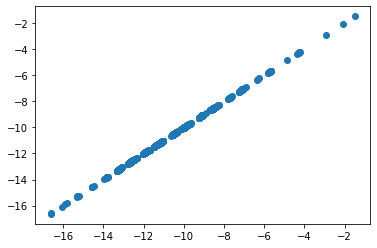

In [96]:
plt.scatter(t, p)

In [97]:
t, p = test_accuracy(vanilla_model, dataset_bdb[:1000])
(((np.array(t)-np.array(p))**2).sum()/len(t)) ** 0.5

100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.28it/s]


66.13329511425619

(-200.0, 0.0)

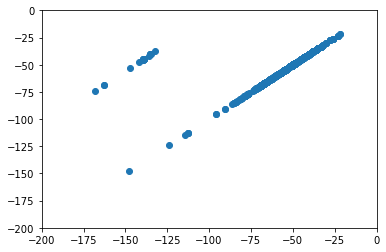

In [98]:
plt.scatter(t, p)
plt.xlim(-200, 0)
plt.ylim(-200, 0)

In [99]:
t, p = test_accuracy(vanilla_model, dataset_cbl[:1000])
(((np.array(t)-np.array(p))**2).sum()/len(t)) ** 0.5

100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.47it/s]


24.083002752669262

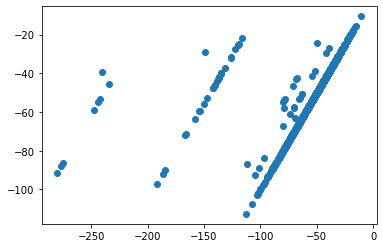

In [101]:
plt.scatter(t, p)
plt.xlim(-150, 0)
plt.ylim(-150, 0)

# Show the result of the vanilla model

In [54]:
vanilla_model = torchani.models.ANI2x(periodic_table_index=True).to(device)

In [60]:
import os
models = os.listdir("./models/synch_torchani_models_20221210/")
test_results = []
for m in tqdm(models, ncols=50):
    model.load_state_dict(torch.load("./models/synch_torchani_models_20221210/" + m))
    test_results.append(test_accuracy(model, dataset_qm[:100]))
temp = []
for t, p in test_results:
    temp.append((((np.array(t)-np.array(p))**2).sum()/len(t)) ** 0.5)
min(temp)

In [61]:
a, b = test_accuracy(vanilla_model, dataset_qm[:5000])
(((np.array(a)-np.array(b))**2).sum()/len(b)) ** 0.5

100%|███████████████████████████████████████| 5000/5000 [01:31<00:00, 54.80it/s]


0.011464223536300054

In [59]:
import os
models = os.listdir("./models/synch_torchani_models_20221210/")
test_results = []
for m in tqdm(models, ncols=50):
    model.load_state_dict(torch.load("./models/synch_torchani_models_20221210/" + m))
    test_results.append(test_accuracy(model, dataset_bdb[:100]))
temp_chembl = []
for t, p in test_results:
    temp_chembl.append((((np.array(t)-np.array(p))**2).sum()/len(t)) ** 0.5)
min(temp_chembl)

In [62]:
a, b = test_accuracy(vanilla_model, dataset_bdb[:5000])
(((np.array(a)-np.array(b))**2).sum()/len(b)) ** 0.5

100%|███████████████████████████████████████| 5000/5000 [01:40<00:00, 49.65it/s]


39.56450639473345

In [58]:
import os
models = os.listdir("./models/synch_torchani_models_20221210/")
test_results = []
for m in tqdm(models, ncols=50):
    model.load_state_dict(torch.load("./models/synch_torchani_models_20221210/" + m))
    test_results.append(test_accuracy(model, dataset_cbl[:100]))
temp_chembl = []
for t, p in test_results:
    temp_chembl.append((((np.array(t)-np.array(p))**2).sum()/len(t)) ** 0.5)
min(temp_chembl)

In [63]:
a, b = test_accuracy(vanilla_model, dataset_cbl[:5000])
(((np.array(a)-np.array(b))**2).sum()/len(b)) ** 0.5

100%|███████████████████████████████████████| 5000/5000 [01:55<00:00, 43.14it/s]


21.886382991763497